# Setting Up the Environment
We need to clone the repository and install the required packages.

In [ ]:
# For Google Colab only
!git clone https://github.com/allie-tran/GuestLecture.git
%cd GuestLecture/

# Installing CLIP
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

Here we have some utility functions to show the results for demonstration purposes.

In [12]:
# Some utils to show images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

data_dir = "coco/val2017"

def image_to_path(image_id):
    return f"{data_dir}/{image_id}"

def show_images(images, shuffle=True):
    if shuffle:
        images = random.sample(list(images), 9)
    else:
        images = images[:9]
    images = [image_to_path(image) for image in images]
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        img = mpimg.imread(images[i])
        ax.imshow(img)
        ax.axis('off')
    plt.show()
    

# Object Detection example using Detr model

In [3]:
"""
Code modified from https://huggingface.co/facebook/detr-resnet-50
"""
from transformers import DetrImageProcessor, DetrForObjectDetection
import torch
from PIL import Image

# load an image
ImageId = "000000002157.jpg"
image = Image.open(ImageId)

# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm"
)
model = DetrForObjectDetection.from_pretrained(
    "facebook/detr-resnet-50", revision="no_timm"
)

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs, target_sizes=target_sizes, threshold=0.9
)[0]

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

Detected carrot with confidence 0.98 at location [453.75, 263.11, 506.06, 294.74]
Detected knife with confidence 0.979 at location [406.89, 214.82, 514.18, 289.54]
Detected knife with confidence 0.984 at location [268.86, 285.66, 330.18, 346.13]
Detected wine glass with confidence 0.992 at location [109.85, 19.3, 180.06, 171.24]
Detected wine glass with confidence 0.946 at location [49.44, 89.46, 98.0, 188.04]
Detected wine glass with confidence 0.964 at location [90.61, 83.36, 154.2, 186.9]
Detected wine glass with confidence 0.999 at location [232.58, 49.94, 297.52, 197.63]
Detected cake with confidence 0.996 at location [11.62, 170.3, 263.61, 362.66]
Detected knife with confidence 0.985 at location [315.88, 309.82, 408.08, 373.97]
Detected wine glass with confidence 0.973 at location [51.06, 51.13, 122.23, 183.69]
Detected wine glass with confidence 0.994 at location [166.44, 65.88, 231.89, 180.87]


# Embedding-based Retrieval

First we need to load the model. Make sure you choose GPU in the Runtime settings.
CPU will be too slow for this model.

In [4]:
import torch
import clip
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"
print("It might take a while to download the model when running for the first time.")
model, preprocess = clip.load("ViT-L/14", device=device)

## Compare image and text similarity
We will use the CLIP model to encdoe the image and text and then compare the similarity between them.

Note: cosine similarity can be calculated using the formula:
$$
\text{similarity} = \frac{A \cdot B}{||A|| \cdot ||B||}
$$

Where A and B are the vectors to be compared.
Hence we need to normalize the vectors before calculating the dot product.

In [5]:
image = preprocess(Image.open("000000002157.jpg")).unsqueeze(0).to(device)
text = clip.tokenize(["I am ordering a coffee at a cafe", "I am hiking in the mountains"]).to(device)

# Encode the image and the text
with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)

# Calculate the similarity
image_features /= image_features.norm(dim=-1, keepdim=True)
text_features /= text_features.norm(dim=-1, keepdim=True)
similarity = (100.0 * image_features @ text_features.T).cpu().numpy()

print("Similarity between the image and the first sentence:", similarity[0, 0])
print("Similarity between the image and the second sentence:", similarity[0, 1])

[[0.95 0.05]]


## Download COCO dataset

In [6]:
# Download MSCOCO 2017 validation images
import requests
import os
from pathlib import Path

# Create a directory
download_dir = Path("coco")
download_dir.mkdir(exist_ok=True)

# Download the images
url = "http://images.cocodataset.org/zips/val2017.zip"
target = download_dir / "val2017.zip"

print("Downloading...")
if not target.exists():
    response = requests.get(url, stream=True)
    with open(target, "wb") as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    os.system(f"unzip {target} -d {download_dir}")

## Extract features from the images

In [8]:
# Load the images
import numpy as np
from torchvision.transforms import functional as F
import os
from tqdm.auto import tqdm 
# Load the images
images = os.listdir("coco/val2017")
print(f"Found {len(images)} images.")
# Encode the images
image_features = []
valid_images = []
print("Encoding images. This might take a while...")
for image in tqdm(images):
    try:
        image_path = f"coco/val2017/{image}"
        img = Image.open(image_path)
        img = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            feature = model.encode_image(img)
            # Normalize the features for cosine similarity (not required, but can help)
            feature = feature / feature.norm(dim=-1, keepdim=True) 
            image_features.append(feature.cpu().numpy())
            valid_images.append(image)
    except Exception as e:
        continue

# Stack the features
image_features = np.stack(image_features) # (N, 768)
print(f"Encoded {len(image_features)} images.")

# Save the features
np.save("image_features.npy", image_features)
np.save("images.npy", valid_images)

Encoding images. This might take a while...


  0%|          | 0/5000 [00:00<?, ?it/s]

/opt/mambaforge-pypy3/envs/katoai-server/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Encoded 212 images.


## Retrieval 

In [9]:
# Load the features
image_features = np.load("image_features.npy")
valid_images = np.load("images.npy", allow_pickle=True)

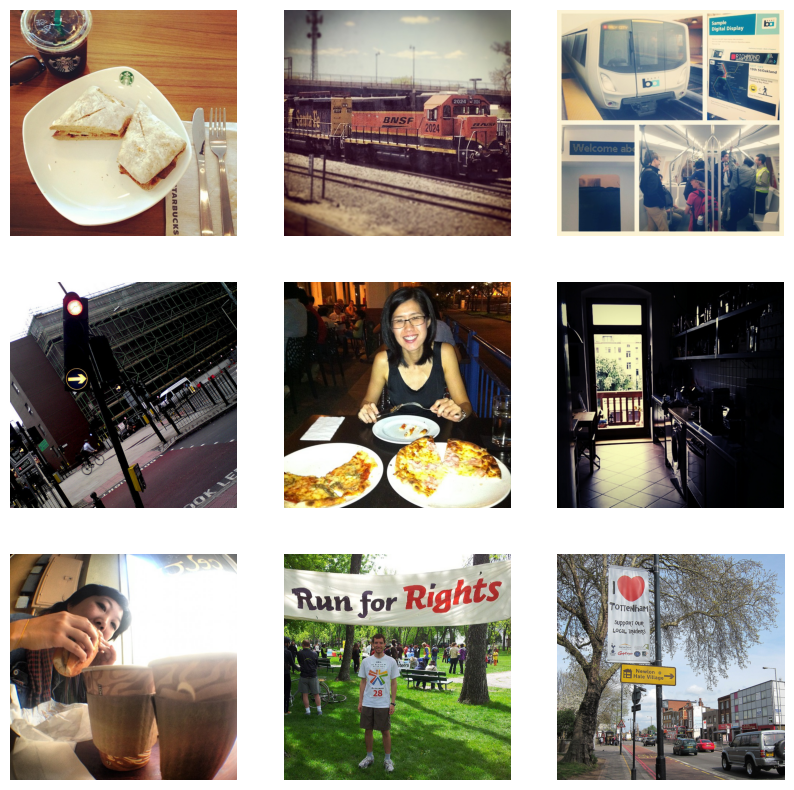

In [13]:
text = "I am ordering a coffee at a cafe"
text = clip.tokenize([text]).to(device)
with torch.no_grad():
    text_features = model.encode_text(text)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.cpu().numpy()

# Calculate the similarity
similarity = (100.0 * image_features @ text_features.T).ravel()

# Show the images with the highest similarity
idx = similarity.argsort()[-9:][::-1]
show_images(np.array(valid_images)[idx], shuffle=False)

# Query by example

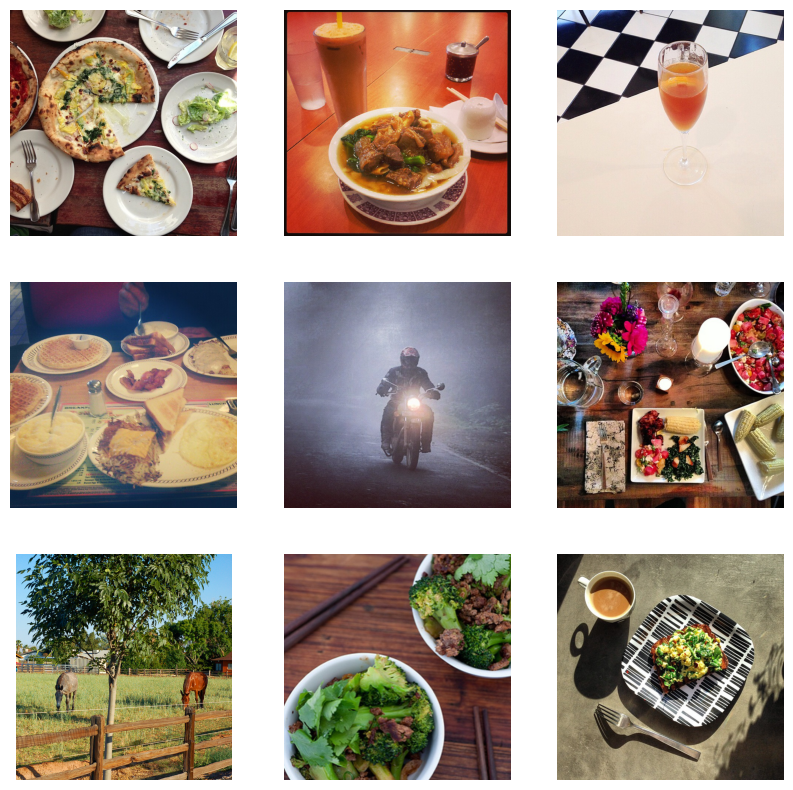

In [17]:
example_image = "000000002157.jpg"
image = Image.open(example_image)
image = preprocess(image).to(device).unsqueeze(0)
with torch.no_grad():
    example_features = model.encode_image(image)
    example_features /= example_features.norm(dim=-1, keepdim=True)
    example_features = example_features.cpu().numpy()

# Calculate the similarity
similarity = (100.0 * image_features @ example_features.T).squeeze()
similarity = similarity.argsort()[-9:][::-1]
show_images(np.array(valid_images)[similarity], shuffle=False)